In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
dataset_obama = pd.read_csv("../datasets/obamaAnonimized.csv", dtype=str)

In [4]:
endorsers_percentage_list = pd.read_csv("../datasets/obama_endorsers_hours_percentage_list.csv", dtype=int, header=None)
endorsers_percentage_list = endorsers_percentage_list.values.tolist()
endorsers_percentage_list = [item for sublist in endorsers_percentage_list for item in sublist]

In [5]:
print(len(endorsers_percentage_list))

4730


In [6]:
# Tolgo 1 in quanto considero la prima epoca come lo stato iniziale
epochs = len(endorsers_percentage_list) - 1

In [7]:
print(len(dataset_obama))

4337


In [8]:
n_nodes = 2678
n_nodes

2678

In [9]:
n_bots = round((1 / 100) * n_nodes)
n_bots

27

In [10]:
n_fact_checkers = round((1 / 100) * n_nodes)
n_fact_checkers

27

In [11]:
n_influencers = 29

In [12]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

2595

In [13]:
n_initial_infected_nodes = round((1 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

0

# Validation for homophily 0.50

In [14]:
# Prendo i parametri calibrati con un dataset diverso da quello usato per la validazione
parameters_homophily_050 = pd.read_csv("./parameters/parameters_optimization_palin_hours_homophily_0.50.csv")

In [15]:
parameters_homophily_050 = parameters_homophily_050.sort_values(by='rmse')
parameters_homophily_050

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
8,0.25,0.50,0.5,0.443859,0.098546,0.127511,0.941369,0.042834,2.061167
13,0.33,0.50,0.5,0.100720,0.029019,0.626069,0.359240,0.451349,3.733030
16,0.50,0.33,0.5,0.856125,0.187407,0.125657,0.702822,0.868028,3.921738
17,0.50,0.50,0.5,0.845530,0.419042,0.237069,0.896393,0.344756,5.846353
7,0.25,0.33,0.5,0.492750,0.005327,0.735202,0.805541,0.050565,8.436895
15,0.50,0.25,0.5,0.092425,0.386219,0.848022,0.999040,0.067329,9.511836
19,0.75,0.25,0.5,0.160062,0.484532,0.858237,0.878654,0.755461,11.697097
9,0.25,0.75,0.5,0.365273,0.504495,0.947275,0.941644,0.877097,11.747540
11,0.33,0.25,0.5,0.252417,0.061354,0.004153,0.993620,0.710981,12.297983
4,0.00,0.75,0.5,0.118196,0.163733,0.220993,0.913153,0.597945,16.072907


In [16]:
alpha = parameters_homophily_050['alpha'].iloc[0]
beta = parameters_homophily_050['beta'].iloc[0]
homophily = parameters_homophily_050['homophily'].iloc[0]
prob_infection = parameters_homophily_050['prob_infection'].iloc[0]
prob_vaccination = parameters_homophily_050['prob_vaccination'].iloc[0]
prob_cure = parameters_homophily_050['prob_cure'].iloc[0]
prob_influencer = parameters_homophily_050['prob_influencer'].iloc[0]
prob_echo = parameters_homophily_050['prob_echo'].iloc[0]

In [17]:
container = NetworksContainer(n_networks=30, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=0.0, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

In [18]:
total_y_pred_list_homophily_050 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_homophily_050.append(y_pred_list)

In [19]:
avg_y_pred_list_homophily_050 = [sum(column) / len(column) for column in zip(*total_y_pred_list_homophily_050)]

In [20]:
std_y_pred_list_homophily_050 = [np.std(column) for column in zip(*total_y_pred_list_homophily_050)]

In [21]:
std_low_y_pred_list_homophily_050 = []
std_high_y_pred_list_homophily_050 = []
for i in range(len(avg_y_pred_list_homophily_050)):
    std_low_y_pred_list_homophily_050.append(avg_y_pred_list_homophily_050[i] - std_y_pred_list_homophily_050[i])
    std_high_y_pred_list_homophily_050.append(avg_y_pred_list_homophily_050[i] + std_y_pred_list_homophily_050[i])

In [22]:
x = []
for i in range(len(endorsers_percentage_list)):
    x.append(i)

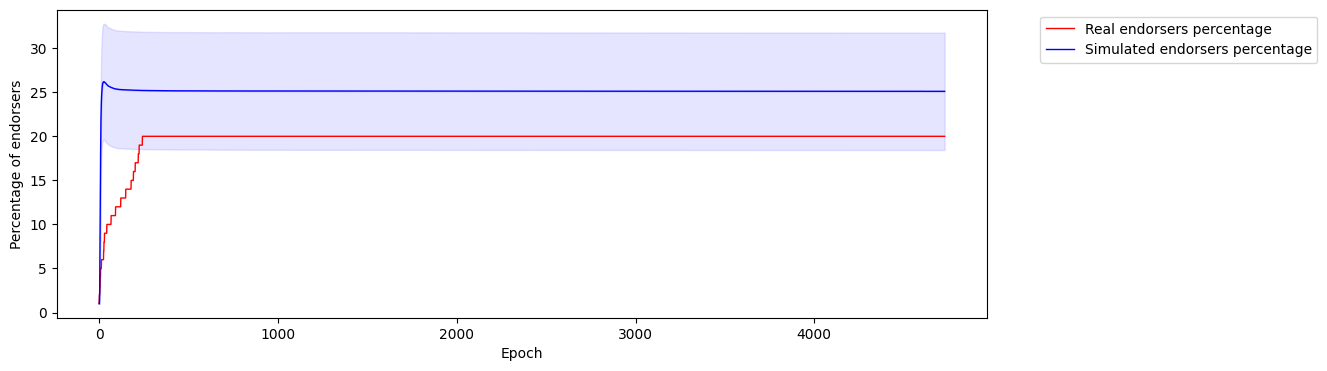

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list, c='r', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_homophily_050, c='b', label='Simulated endorsers percentage', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_homophily_050, std_low_y_pred_list_homophily_050, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_homophily_050, std_high_y_pred_list_homophily_050, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [24]:
x = []
endorsers_percentage_list_truncated = []
avg_y_pred_list_homophily_050_truncated = []
std_low_y_pred_list_homophily_050_truncated = []
std_high_y_pred_list_homophily_050_truncated = []
for i in range(500):
    x.append(i)
    endorsers_percentage_list_truncated.append(endorsers_percentage_list[i])
    avg_y_pred_list_homophily_050_truncated.append(avg_y_pred_list_homophily_050[i])
    std_low_y_pred_list_homophily_050_truncated.append(std_low_y_pred_list_homophily_050[i])
    std_high_y_pred_list_homophily_050_truncated.append(std_high_y_pred_list_homophily_050[i])

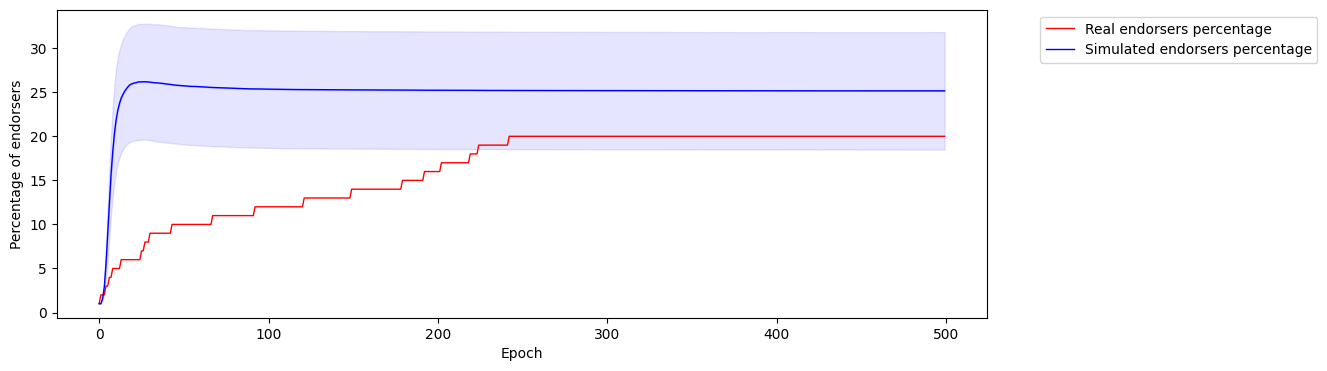

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list_truncated, c='r', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_homophily_050_truncated, c='b', label='Simulated endorsers percentage', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_homophily_050_truncated, std_low_y_pred_list_homophily_050_truncated, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_homophily_050_truncated, std_high_y_pred_list_homophily_050_truncated, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [26]:
y_true = endorsers_percentage_list

neg_rmse_list_homophily_050 = []
for i in range(container.n_networks):
        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_homophily_050[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_homophily_050.append(neg_rmse)
    
mean_neg_rmse_homophily_050 = np.mean(neg_rmse_list_homophily_050)
std_neg_rmse_homophily_050 = np.std(neg_rmse_list_homophily_050)
print("Mean 0.50: ", mean_neg_rmse_homophily_050)
print("Standard deviation 0.50: ", std_neg_rmse_homophily_050)

Mean 0.50:  -7.922539540453328
Standard deviation 0.50:  3.8830498255554415


In [27]:
df_total_y_pred_list_homophily_050 = pd.DataFrame(total_y_pred_list_homophily_050).T
df_total_y_pred_list_homophily_050.to_csv("validation_obama_endorsers_percentages_homophily_0.50.csv", index=False, header=False)

In [28]:
df_statistics_homophily_050 = pd.DataFrame(avg_y_pred_list_homophily_050).T
df_statistics_homophily_050.loc[1] = std_y_pred_list_homophily_050
df_statistics_homophily_050.loc[2] = std_high_y_pred_list_homophily_050
df_statistics_homophily_050.loc[3] = std_low_y_pred_list_homophily_050
df_statistics_homophily_050.to_csv("validation_obama_statistics_homophily_0.50.csv", index=False, header=False)

In [29]:
df_rmse_homophily_050 = pd.DataFrame(neg_rmse_list_homophily_050).T
df_rmse_homophily_050.to_csv("validation_obama_rmse_homophily_0.50.csv", index=False, header=False)